In [107]:
import pickle, json
import os, sys

dic = pickle.load(open("demo/custom_prediction.pk", "rb"))
dic = {os.path.basename(k): v for k, v in dic.items()}

# VG1800
# vocab = json.load(open("../datasets/vg/1000/VG-dicts.json"))

# VG50
vocab = json.load(open("../datasets/vg/50/VG-SGG-dicts-with-attri.json"))



In [108]:
dic.keys()

dict_keys(['COCO_train2014_000000580957.jpg', 'COCO_val2014_000000000073.jpg', 'COCO_val2014_000000000074.jpg'])

In [109]:
dic[list(dic.keys())[0]].keys()

dict_keys(['bbox', 'bbox_labels', 'bbox_scores', 'rel_pairs', 'rel_labels', 'rel_scores'])

31-motorcycle, parked on, 19-street tensor(0.0261)
5-bike, parked on, 19-street tensor(0.0200)
24-motorcycle, parked on, 19-street tensor(0.0162)
3-number, on, 5-bike tensor(0.0109)
30-number, on, 5-bike tensor(0.0096)
2-number, on, 5-bike tensor(0.0087)
5-bike, has, 25-seat tensor(0.0082)
8-number, on, 5-bike tensor(0.0082)
12-number, on, 5-bike tensor(0.0081)
29-letter, painted on, 31-motorcycle tensor(0.0075)
26-number, on, 5-bike tensor(0.0071)
5-bike, has, 17-wheel tensor(0.0067)
29-letter, painted on, 32-motorcycle tensor(0.0066)
31-motorcycle, has, 1-wheel tensor(0.0065)
27-bike, has, 17-wheel tensor(0.0065)
1-wheel, on back of, 31-motorcycle tensor(0.0062)
27-bike, has, 25-seat tensor(0.0058)
17-wheel, of, 27-bike tensor(0.0057)
39-engine, of, 5-bike tensor(0.0054)
5-bike, has, 1-wheel tensor(0.0052)
2-number, painted on, 24-motorcycle tensor(0.0049)
5-bike, has, 0-seat tensor(0.0049)
31-motorcycle, has, 6-tire tensor(0.0047)
21-letter, painted on, 31-motorcycle tensor(0.0047)


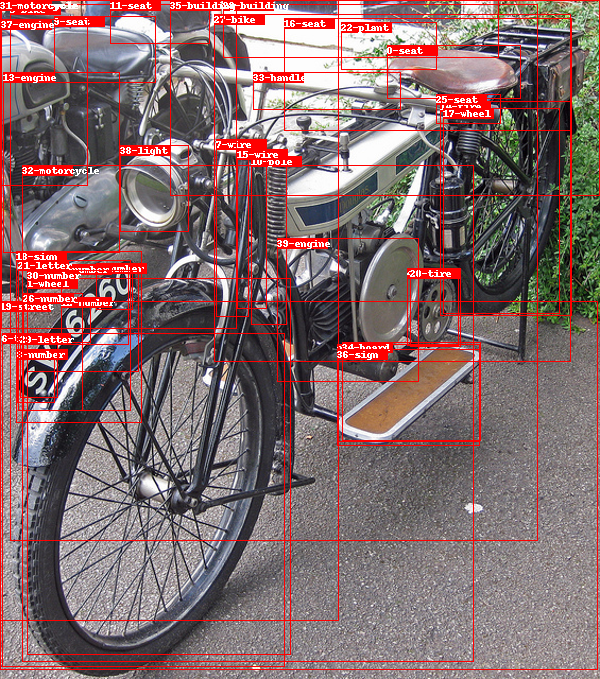

In [110]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

box_topk = 40
rel_topk = 30

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def draw_image(img_path, data):
    img_path = os.path.join("./demo_imgs", img_path)
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    boxes = np.array(data['bbox'][:box_topk])
    labels = data['bbox_labels']
    labels = [str(i)+"-"+vocab['idx_to_label'][str(int(x))] for i, x in enumerate(labels)]
    
    
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    
    
    all_rel_pairs = data['rel_pairs']
    all_rel_labels = data['rel_labels']
    all_rel_scores = data['rel_scores']
#     all_rel_trip_scores = data['rel_all_scores']
    
#     all_na_scores = torch.zeros([len(all_rel_trip_scores), 2])
#     all_na_scores[:, 0] = all_rel_trip_scores[:, 0]
#     all_na_scores[:, 1] = all_rel_trip_scores[:, 1:].sum(1)
#     all_na_scores = all_na_scores.softmax(-1)
#     all_na_scores, idxs = (all_na_scores[:, 1]*all_rel_scores).sort(descending=True)
# #     all_na_scores, idxs = (all_na_scores[:, 0]).sort()
#     all_rel_pairs = all_rel_pairs[idxs]
#     all_rel_labels = all_rel_labels[idxs]
#     all_rel_scores = all_rel_scores[idxs]
    
    
    rel_pairs = []
    rel_labels = []
    rel_scores = []
    na_scores = []
    for i in range(len(all_rel_pairs)):
        if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
            rel_scores.append(all_rel_scores[i])
            label = labels[all_rel_pairs[i][0]] + ', ' + vocab["idx_to_predicate"][str(int(all_rel_labels[i]))] + ', ' + labels[all_rel_pairs[i][1]]
            rel_labels.append(label)

    rel_labels = rel_labels[:rel_topk]
    rel_scores = rel_scores[:rel_topk]
    for a, b in list(zip(rel_labels, rel_scores)):
        print(a, b)
    
    display(pic)
    return None

keys = list(dic.keys())
key = keys[1]
draw_image(key, dic[key])